# Expanding on Ito et al. (2017) to recover simulated task activity and connectivity matrix


Set up environment

In [1]:
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

Import custom modules

In [2]:
sys.path.append('../')
sys.path.append('../../utils/')

# Primary module with most model functions
import model

# Module for FC regression
import multregressionconnectivity as mreg

Helper functions

In [3]:
phi = lambda x: np.tanh(x)

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def pshift(y,p):
    y_lag = np.roll(y, p)
    y_lag[:p] = 0
    return y_lag


## Neural network level

In this notebook we expand on simulations described in [Ito et al. (2017)](https://www.nature.com/articles/s41467-017-01000-w.pdf). Ito et al. propose a dynamic neural network model to simulate resting state and task data. Accordingly change in activity in each node is a function of the local connectivity determined by $s$, global connectivity determined by $g$ and task activity for that node described in $I$

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}


where transformation function $\phi$ is
\begin{equation*}
\phi(x) = \tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{2x}-1}{e^{2x}+1}
\end{equation*}

This transformation is intended to introduce *"a nonlinearity to the interactions among units that is
similar to aggregate nonlinearity from neuronal action potentials"* as explained in [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). The effect of this transformation can be seen below in the attenuated signal of the transformed timeseries.

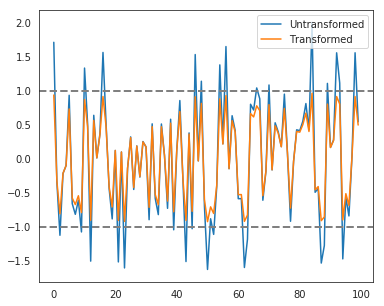

In [4]:
plt.rcParams["figure.figsize"][0] = 6
plt.rcParams["figure.figsize"][1] = 5
a = np.random.normal(size=100)
pa = phi(a)
plt.plot(a, label="Untransformed")
plt.plot(pa, label="Transformed")
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axhline(y=-1,linewidth=2, color='gray', ls = "--")
plt.legend()

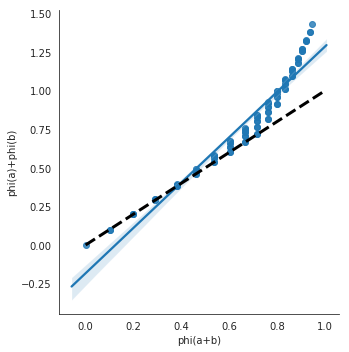

In [21]:
df = pd.DataFrame(data = {'a':np.repeat(np.arange(0,1,.1), 10), 'b': np.tile(np.arange(0,1,.1), 10)})
df['phi(a+b)'] = phi(df['a']+df['b'])
df['phi(a)+phi(b)'] = phi(df['a']) + phi(df['b'])

sns.lmplot(x = 'phi(a+b)', y = 'phi(a)+phi(b)', data = df)
plt.plot((0, 1), (0, 1), 'k--', linewidth=3)

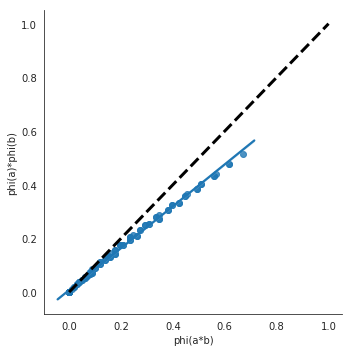

In [22]:
df = pd.DataFrame(data = {'a':np.repeat(np.arange(0,1,.1), 10), 'b': np.tile(np.arange(0,1,.1), 10)})
df['phi(a*b)'] = phi(df['a']*df['b'])
df['phi(a)*phi(b)'] = phi(df['a']) * phi(df['b'])

sns.lmplot(x = 'phi(a*b)', y = 'phi(a)*phi(b)', data = df)
plt.plot((0, 1), (0, 1), 'k--', linewidth=3)

For simplicity $\tau_i$, $s$ and $g$ are set to 1. The equation can then be rewritten as:

\begin{equation*}
x_i(t) + \frac{dx_i}{dt} = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

\begin{equation*}
x_i(t+1) = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

vectorizing the matrix multiplication

\begin{equation*}
x_i(t+1) = \phi\big(x_i(t)\big) + w_{i1}\phi\big(x_1(t)\big) + w_{i2}\phi\big(x_2(t)\big)... +  w_{iN}\phi\big(x_N(t)\big) + I_i(t)
\end{equation*}

with the observable activity levels in each node at every time point we should be able to use a regression framework to receover the weights in the connectivity matrix.

\begin{equation*}
x_i(t+1) = \beta_{1}\phi\big(x_i(t)\big) + \beta_{2}\phi\big(x_1(t)\big) + \beta_{3}\phi\big(x_2(t)\big) ... +  \beta_{N}\phi\big(x_N(t)\big) + \beta_{N+1}I_i(t)
\end{equation*}

Thus $\beta_1$ should be recursivity (and 1) while all the other parameter estimates should map onto the afferent/incoming connection weights

***Create structural and synaptic network***

One hub and two local networks

In [23]:
# Parameters for subject's networks
ncommunities = 3
innetwork_dsity = .60
outnetwork_dsity = .08
hubnetwork_dsity = .25

nodespercommunity = 35
totalnodes = nodespercommunity*ncommunities

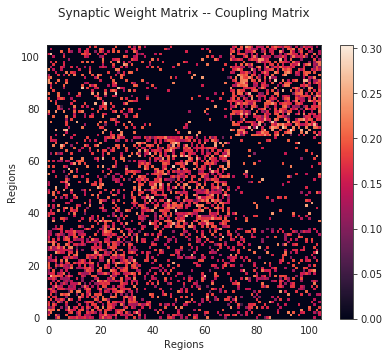

In [24]:
# Construct structural matrix
W = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=False)
# Construct synaptic matrix
G = model.generateSynapticNetwork(W, showplot=True)

Note in this matrix:

`G[..., x]` : column x of matrix denotes all outgoing connection weights from node x  
`G[x, ...]` : row x of matrix denotes all incoming connection weights to node x

### Rest activity

***Simulate resting state activity***

Apply neural network model **(Eq 3 in paper)** to the connectivity matrix and calculate each nodes' activity for each time point


**Note that this is still in synaptic space (i.e. not convolved)**

In [25]:
## Set up simulation parameters
#Tmaxrest = 60000 # 1min resting state data
Tmaxrest = 300000 # 5min resting state data
dt = 1.0
tau = 1.0
g = 1.0
s = 1.0

When generating `restdata` the `noise` argument is not set to `None` because change in activity is defined as `spont_act = (noise[:,t] + I[:,t])`. When there is no task defined in `I` if `noise` is set to `None` then there is no activity. Thus `restdata` is conceived of as just noise.

In [ ]:
restdata = model.networkModel(G, 
                              Tmax=Tmaxrest,
                              dt=dt,
                              g=g,
                              s=s,
                              tau=tau,
                              I=None,
                              noise = 1)[0]

In [ ]:
plt.figure()
plt.imshow(restdata, aspect='auto',origin='lower')
plt.title('Simulated resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

### Task activity 

***Hub network stimulation***

In [26]:
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) # Construct a community affiliation vector
hub_ind = np.where(Ci==0)[0] # Identify the regions associated with the hub network (hub network is by default the 0th network)

# Set number of time points for each task
#Tmax = 10000
Tmax = 300000 #increased to 5 minutes

T = np.arange(0,Tmax,dt)
    
# Construct timing array for convolution -- this timing is irrespective of the task being performed
# Tasks are only determined by which nodes are stimulated
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%2000>500 and t%2000<1000:
        tasktiming[0,t] = 1.0

Block design where stimulus is ON for 500 ms every 2 seconds looks like:

(-0.1, 1.2)

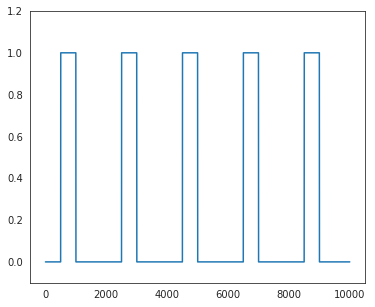

In [27]:
plt.plot(T[:10000], tasktiming[0,:10000])
plt.ylim(top = 1.2, bottom = -0.1)

In [28]:
stimtimes = {}

topdown_only = range(1,2)
task = 1

taskcount = task-np.min(topdown_only)
stimsize = np.floor(nodespercommunity/4.0)
stim_nodes = np.arange((taskcount)*stimsize,(taskcount)*stimsize+stimsize,dtype=int)
stimtimes[task] = np.zeros((totalnodes,len(T)))

# When task is ON the activity for a stim_node at that time point is .5
for t in range(len(T)):
    if tasktiming[0,t] == 1:
        stimtimes[task][stim_nodes,t] = .5

Activated nodes in the hub network *only* (making it a top-down task) are:

In [29]:
stim_nodes

array([0, 1, 2, 3, 4, 5, 6, 7])

In [30]:
out = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1)
taskdata = out[0]
noise = out[1]
#taskdata = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
#                                          I=stimtimes[task], noise=1)

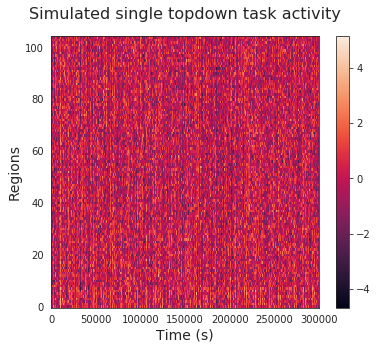

In [31]:
plt.figure()
plt.imshow(taskdata, aspect='auto',origin='lower')
plt.title('Simulated single topdown task activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

## Extending GLM to recover true task activity and connectivity matrix

Note: Extending the GLM in this way is intended to account for the connectivity between nodes and how **task** activity in the previous step affects task activity in the current step for a given node. I don't think this is the same thing as 'subtracting out' resting state to look at the remaining task activity.

In [32]:
#Using first third of the data for speed of estimation
taskdata_short = copy.copy(taskdata[:,:10000])

In [49]:
x = copy.copy(stimtimes[task][0,:10000].T)
y = copy.copy(taskdata_short)
I = stimtimes[task][:,:10000]

In [34]:
ntimepoints = y.shape[1]
nregions = y.shape[0]

#Initialize empty variables
ucr_task = np.zeros((nregions))
ext_cur_node = np.zeros((nregions)) 
ext_weight_matrix = np.zeros((nregions, nregions-1))
ext_task = np.zeros((nregions))
ext_phi_weight_matrix = np.zeros((nregions, nregions-1))
ext_phi_phi_cur_node = np.zeros((nregions))
ext_phi_task = np.zeros((nregions))

In [102]:
for region in range(0, nregions):
    
    cur_y = y[region,:]
    task_reg = I[region,:]

    ucr_mod = sm.OLS(cur_y, task_reg)
    ucr_res = ucr_mod.fit()
    ucr_task[region] = ucr_res.params[0]

    #Extended model 
    next_y = 2*cur_y[1:] #shift column up to predict next multiplied activity

    cur_y = cur_y[:-1] #drop last time point

    drop_region = [region]
    other_ns_next_spont = np.delete(I, drop_region, axis=0)[:,1:] #dropping first col/timepoint
    other_ns_next_spont = other_ns_next_spont.T

    cur_n_next_spont = I[region,1:]

    other_ns_cur_spont = np.delete(I, drop_region, axis=0)[:,:-1] #dropping last col/timepoint
    other_ns_cur_spont = other_ns_cur_spont.T
    other_ns_cur_spont = np.apply_along_axis(phi, 0, other_ns_cur_spont)

    cur_y_phi_phi = phi(phi(cur_y))

    cur_n_cur_spont = phi(I[region,:-1])

    ext_des_mat = np.concatenate((cur_y.reshape(-1,1), other_ns_next_spont), 1)
    ext_des_mat = np.concatenate((ext_des_mat, cur_n_next_spont.reshape(-1,1)), 1)
    ext_des_mat = np.concatenate((ext_des_mat, other_ns_cur_spont), 1)
    ext_des_mat = np.concatenate((ext_des_mat, cur_y_phi_phi.reshape(-1,1)), 1)
    ext_des_mat = np.concatenate((ext_des_mat, cur_n_cur_spont.reshape(-1,1)), 1)

    ext_mod = sm.OLS(next_y, ext_des_mat)
    ext_res = ext_mod.fit()
    ext_params = ext_res.params

    ext_cur_node[region] = ext_params[0]
    ext_weight_matrix[region,:] = ext_params[1:nregions]
    ext_task[region] = ext_params[nregions]
    ext_phi_weight_matrix[region,:] = ext_params[nregions+1:2*nregions]
    ext_phi_phi_cur_node[region] = ext_params[-2]
    ext_phi_task[region] = ext_params[-1]

#### Task betas reduced after correction?


In [ ]:
task_betas = pd.DataFrame(data = {'task_glm': out['task_glm'],
                         'task_ext_ucr': out['task_ext_ucr'],
                         'task_ext_arc': out['task_ext_arc'],
                         'task_ext_pw': out['task_ext_pw']})

In [ ]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 6
plt.plot(task_betas['task_glm'], color = "blue", label = "Classic GLM")
plt.plot(task_betas['task_ext_ucr'], color = "green", label = "Extended GLM no ARC")
plt.plot(task_betas['task_ext_arc'], color = "red", label = "Extended GLM ARC")
plt.plot(task_betas['task_ext_pw'], color = "purple",label = "Extended GLM PW")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='gray', ls = "--")
plt.axhline(y=0,linewidth=2, color='gray', ls = "--")
plt.axvline(x=35,linewidth=2, color='gray', ls = "--")
plt.axvline(x=70,linewidth=2, color='gray', ls = "--")
plt.legend(loc="best")

#### Current node betas == 1?

In [ ]:
cur_node_betas = pd.DataFrame(data = {'cur_node_ext_ucr': out['cur_node_ext_ucr'],
                         'cur_node_ext_arc': out['cur_node_ext_arc'],
                         'cur_node_ext_pw': out['cur_node_ext_pw']})

In [ ]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 6
plt.plot(cur_node_betas['cur_node_ext_ucr'], color = "green",label = "Extended GLM no ARC")
plt.plot(cur_node_betas['cur_node_ext_arc'], color = "red",label = "Extended GLM ARC")
plt.plot(cur_node_betas['cur_node_ext_pw'], color = "purple",label = "Extended GLM PW")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axvline(x=35,linewidth=2, color='gray', ls = "--")
plt.axvline(x=70,linewidth=2, color='gray', ls = "--")
plt.legend(loc="best")

#### Other node betas recapitulate connectivity matrix?

**Relationship between other nodes betas and the afferent connectivity weights (can you recover the connectivity matrix?)**

In [ ]:
nregions = y.shape[0]
weight_matrix_betas_ucr = np.zeros((nregions,nregions))
weight_matrix_betas_arc = np.zeros((nregions,nregions))
weight_matrix_betas_pw = np.zeros((nregions,nregions)) 
for i in range(nregions):
    weight_matrix_betas_ucr[i] = np.insert(out['weight_matrix_ext_ucr'][i],i,0)
    weight_matrix_betas_arc[i] = np.insert(out['weight_matrix_ext_arc'][i],i,0)
    weight_matrix_betas_pw[i] = np.insert(out['weight_matrix_ext_pw'][i],i,0)

In [ ]:
plt.figure()
plt.imshow(weight_matrix_betas_ucr, origin='lower')
plt.colorbar()
plt.title("Coefficients for other nodes' activity", y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

In [ ]:
plt.figure()
plt.imshow(weight_matrix_betas_arc, origin='lower')
plt.colorbar()
plt.title("Coefficients for other nodes' activity", y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

In [ ]:
plt.figure()
plt.imshow(weight_matrix_betas_pw, origin='lower')
plt.colorbar()
plt.title("Coefficients for other nodes' activity", y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()